<a href="https://colab.research.google.com/github/staniya/CT_image_analysis/blob/main/BAL_RS_Ver2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 間質性肺炎の予後予測因子の抽出と予後予測のランダムフォレストモデル

**TODO: 柴木様**

下記に加え、図表などで今回の解析内容の説明

線維化を伴う間質性肺炎の急性増悪の多施設後ろ向き実態調査に付随した研究として、予後予測因子の抽出と予後予測の新規モデルを作成します。和歌山医科大学の保有する、線維化を伴う間質性肺炎の急性増悪の多施設後ろ向き実態調査に登録された患者において急性増悪中に施行されたBAL液中のサイトカインやケモカインのデータを用いて、間質性肺炎の予後予測因子の抽出と予後予測の新規モデルを作成します。

今回の解析は分類問題であるため、ランダムフォレスト分類器が使用されます。Scikit-learnライブラリから、RandomForestClassifierを持つアンサンブルパッケージが使用されます。ランダムフォレストは、平均化を使用して予測精度を向上させ、特定のデータセットのさまざまなサブサンプルに多数の決定木分類器を適合させることで過剰適合を制御するメタ推定量です。

## 環境構築

本章では、下記のライブラリを利用します。

*  Collections  
*  Data Synthesizer
*  Google Colab
*  Joblib
*  Matplotlib
*  Numpy
*  Optuna
*  os
*  Pandas
*  Seaborn
*  Scikit-learn
*  sys
*  TensorFlow


以下のセルを実行（Shift + Enter)して必要なライブラリをインストールして下さい。

In [4]:
!python -m pip install openpyxl==3.0
!pip install -q DataSynthesizer
!pip install optuna
!apt-get install tree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


インストールが完了したら以下のセルを実行して，各ライブラリのインポート，及びバージョン確認を行って下さい.

In [5]:
from collections import OrderedDict

import DataSynthesizer
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

from google.colab import drive
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import optuna
import os
import pandas as pd
import seaborn as sns

import sklearn
from sklearn import tree
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

import sys
sys.path.append('models')

import tensorflow as tf

print("Data Synthesizer: ", DataSynthesizer.__version__)
print("Google Colab Python: ")
!python --version
print("\nJoblib: ", joblib.__version__)
print("Matplotlib: ", mpl.__version__)
print("Numpy: ", np.__version__)
print("Optuna: ", optuna.__version__)
print("pandas: ", pd.__version__)
print("Seaborn: ", sns.__version__)
print("Scikit-learn: ", sklearn.__version__)
print("TensorFlow: ", tf.__version__)

Data Synthesizer:  0.1.11
Google Colab Python: 
Python 3.7.13

Joblib:  1.1.0
Matplotlib:  3.2.2
Numpy:  1.21.6
Optuna:  2.10.0
pandas:  1.3.5
Seaborn:  0.11.2
Scikit-learn:  1.0.2
TensorFlow:  2.8.0


## BAL研究について

**TODO: 柴木様**

BAL研究の説明及び図表をここに入れる

## 使用するデータセット

**TODO: 柴木様**

データセットについての説明文

In [6]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/shibaki analysis/AE-FILD BAL patient_data.xlsx' patient_data.xlsx

Mounted at /content/drive


無事ダウンロードが完了すると， /content/driveフォルダがローカル環境にマウントされます。

## データ前処理

ダウンロードしたファイルを読み込み，機械学習モデルへの入力形式に変換するデータ前処理を以下の手順で行います。

1. ヘルパーファンクションでデータフレームテキスト内の"\n"をスペースに変換する関数を定義する
2. 学習に不必要なデータコラムを除外する: "No"
3. sklearnのSimpleImputerを導入し欠損値（NaN)補完を行う
    - 補完方法は中央値で欠損値を埋める（[[1](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)]を参考）
4. テスト用のデータをホールドアウト法に基づき先に取り分けておく
5. 学習用のデータが不足しているためDataSynthesizerライブラリーを導入し模擬データを作成する
    - ベイジアンネットワークを使用して合成データセットを作成する方法はこちらを参考して下さい [[2](https://www.scb.se/contentassets/ca21efb41fee47d293bbee5bf7be7fb3/using-bayesian-networks-to-create-synthetic-data.pdf)]

まずは以下のセルを実行して、データ前処理クラスを定義します。
全処理クラス内では、以下のメンバ関数を定義しています。

* __init__() (コンストラクタ）: 変数の初期化，学習用とテスト用への分割ルール，利用するラベルの集約ルール
* clean_header(): Pandasデータフレームのヘッダー内の"\n"をスペースに変換する関数
* convert_text_to_list(): Pandasデータフレームのヘッダーをリストに変換する関数
* drop_columns(): 学習に不必要な項目をdrop()する関数
* data_imputation(): sklearnのSimpleImputerを導入し欠損値（NaN)補完を行う関数
* def remove_header_map(): Pandasデータフレームのヘッダー内にカテゴリカル変数が含まれる場合、数値と置き換える関数
* def split(): テスト用のデータを分割する為の関数
* def create_data_synthesis_network(): 模擬データを作成するためのベイジアンネットワークモデルの定義・学習を行う関数
* def generate_synthetic_data(): 学習済のベイジアンネットワークモデルを使い模擬データを実際に作成する関数
* def synthetic_data_wrapper(): 学習済のDataDescriberのモデルが存在するかを確認する関数
* def main(): 上記全ての工程を一度に実行するためのメイン関数




In [7]:
# 出力ディレクトリーの作成
!mkdir ./out

# description_fileをグーグルドライブから引っ張ってくる
!cp '/content/drive/MyDrive/shibaki analysis/description.json' ./out/description.json

# synthetic_dataをグーグルドライブから引っ張ってくる
!cp '/content/drive/MyDrive/shibaki analysis/synthetic_data.csv' ./out/synthetic_data.csv

cp: cannot stat '/content/drive/MyDrive/shibaki analysis/description.json': No such file or directory
cp: cannot stat '/content/drive/MyDrive/shibaki analysis/synthetic_data.csv': No such file or directory


In [8]:
class BaseBALDatasetProcessor(object):
    def __init__(
        self,
        dataset,
        dataset_root,
        dataframe_name,
    ):
        # 模擬データが元のデータの類似するように模擬データの作成設定をcorrelated_attribute_modeにする
        self.mode = 'correlated_attribute_mode'
        self.dataset = dataset
        self.dataset_root = dataset_root
        self.dataframe_name = dataframe_name

        # Holdout法に基づき先に学習用のデータを分割したデータフレーム
        self.augment_training_df = pd.DataFrame()

        # 模擬データの構造を説明するための情報ファイル等の指定
        if os.path.exists(f'./out/description.json') and os.path.exists(f'./out/synthetic_data.csv'):
            self.description_file = f'./out/description.json'
            self.synthetic_data = f'./out/synthetic_data.csv'

        else:
            self.output_dir = f'./out'
            self.description_file = f'./out/description.json'
            self.synthetic_data = f'./out/synthetic_data.csv'

        # データセットをPandasのデータフレームとして読み込む
        self.dataframe = pd.read_excel(self.dataset, engine='openpyxl')

        # データセット内のカテゴリカル変数の数値をその数値が表すカテゴリーに置き換える必要がある際
        self.columnname_dict = OrderedDict([
            ('90day-mortality', {0.0: 'survival', 1.0: 'death'}),
            ('sex', {0.0: 'male', 1.0: 'female'}),
            ('smoking-status',
             {0.0: 'Never',
                   1.0: 'Ex(quit smoking over a year ago)',
                   2.0: 'Current'}),
            ('emphysema', {0.0: '-', 1.0: '+'}),
            ('Baseline-ILD',
             {0.0: 'UIP',
                   1.0: 'probable UIP',
                   2.0: 'Indeterminate for UIP',
                   3.0: 'Alternative diagnosis'}),
            ('Collagen-disease', {0.0: '-', 1.0: '+'}),
            ('IPAF', {0.0: '-', 1.0: '+'})])

    def clean_header(
        self,
        text
    ):
        """
        Pandasデータフレームのヘッダー内の"\n"をスペースに変換する関数
        """
        text = text.strip()
        text = text.replace(" ", "-")
        text_n_newline = text.replace("\n", " ")
        return text_n_newline

    def convert_text_to_list(self):
        """
        Pandasデータフレームのヘッダーをリストに変換する関数
        """
        df_header_list = self.dataframe.columns.values.tolist()
        df_header_list_cleaned = [self.clean_header(x) for x in df_header_list]
        self.dataframe.columns = df_header_list_cleaned

    def drop_columns(
        self,
        col_names=["No"]
    ):
        """
        学習に不必要な項目をdrop()する関数
        """
        self.dataframe = self.dataframe.drop(columns=col_names)

    def data_imputation(
        self,
        null_val='NaN',
        strategy='median'
    ):
        """
        sklearnのSimpleImputerを導入し欠損値（NaN)補完を行う関数
        """
        if null_val == 'NaN':
            nan_attr = np.NaN
        else:
            print("Declare valid null data value for variable null_val")
        # データフレーム内の"NaN"をnumpyのNaNと置き換える)
        self.dataframe.replace(null_val, nan_attr, inplace=True)
        # sklearnのSimpleImputerを使い、np.NaNをnull値として認識させる。
        # 加、strategy="median"はnp.NaNをその行のNaNを中央値と置き換えるための指定
        imp = SimpleImputer(missing_values=nan_attr, strategy=strategy)
        df_idf = pd.DataFrame(imp.fit_transform(self.dataframe))
        # SimpleImputerは数値しか作成できない為、元のデータセットの行名を新しいデータセットに加るコード
        df_idf.columns = self.dataframe.columns
        self.dataframe = df_idf

    def remove_header_map(
        self,
        text
    ):
        """
        Pandasデータフレームのヘッダー内にカテゴリカル変数が含まれる場合、数値と置き換える関数
        """
        for key in self.columnname_dict.keys():
            if key in text:
                text = key
        return text

    def split (
      self,
      # Y (ラベル) ターゲットラベル
      Y_col = '90day-mortality',
      # テスト用データの割合
      ts = 0.20,
      # 検証用でデータの割合
      vs = 0.40,
      # ランダムステート 
      rs = 42
    ):
      """
      学習用・テスト用・検証用に分割するための関数
      """
      # ヘッダーコラムのテキストを記号と置き換える必要がある場合
      df_header_list = self.dataframe.columns.values.tolist()
      df_header_list_cleaned = [self.remove_header_map(
          x) for x in self.columnname_dict]
      for column in self.dataframe:
          for header in df_header_list_cleaned:
              if header in column:
                  self.dataframe.rename(
                      columns={column: header}, inplace=True)
                  
      # X (フィーチャー) ターゲットラベル以外の全ての行
      X_cols = self.dataframe.loc[:, self.dataframe.columns != Y_col].columns

      # テストデータ分割（初期の分割ではtrainに学習用・検証用データが含まれ, testにテストデータが含まれる)
      X_train, self.X_test, y_train, self.y_test = \
      train_test_split(
          self.dataframe[X_cols], 
          self.dataframe[Y_col],
          test_size=ts, 
          random_state=rs, 
          stratify=self.dataframe[Y_col]
          )
      
      # 学習用・検証用データ分割
      X_train, X_val, y_train, y_val = \
      train_test_split(
          X_train, 
          y_train,
          test_size=vs, 
          random_state=rs,
          stratify=y_train
          )
      
      # テスト用データからIDをドロップする
      self.X_test = self.X_test.drop(columns=['ID'])
      
      # 学習用のデータをデータフレームに付け加える
      X_temp_df = pd.concat([X_train, X_val], axis=0)
      y_temp_df = pd.concat([y_train, y_val], axis=0)
      self.augment_training_df = pd.concat([X_temp_df, y_temp_df], axis=1)

    def create_data_synthesis_network(
        self,
        # データの要素を識別できるように、IDをデータのキーとして認識する
        candidate_keys={'ID': True},
        categorical_attr_index=9,
        categorical_attr_incl=['ID', 'age', 'Brinkman-Index'],

        # ベイジアンネットワークパラメーター指定
        # ドメインサイズがこのしきい値よりも小さい場合、属性はカテゴリーに分類されます。
        # 今回のデータでは一番多いカテゴリー要素が4だったので、閾値を4と指定する
        threshold_value=4,

        # 差分プライバシーのパラメーター。 これは、入力データセットの行を削除しても、exp（epsilon）の乗法差以上に同じ出力を取得する確率が変わらないことを大まかに意味します。
        # イプシロン値を増やすことで学習モデルのノイズを減らせます。 差分プライバシーをオフにするにはepsilon = 0を設定します。
        epsilon=1,

        # ベイジアンネットワーク内の親ノードの最大数、つまり、有向グラフでの入力エッジの最大数。
        degree_of_bayesian_network=2
    ):
        """
        模擬データを作成するためのベイジアンネットワークモデルの定義・学習を行う関数
        """
        # PandasのデータフレームをDataSynthesizerが応用できるようにcsvに変換する
        self.augment_training_df.to_csv(self.dataframe_name + '.csv', index=False)

        # データフレーム内の0−9行の内age以外の行はカテゴリカルなため、模擬データを作成出来るようにカテゴリかルアトリビュートとして認識する
        categorical_attributes = {}

        for columns in list(self.augment_training_df.columns[:categorical_attr_index]):
            if columns not in categorical_attr_incl:
                categorical_attributes[columns] = True

        # DataDescriberをインスタンス化する
        describer = DataDescriber(category_threshold=threshold_value)

        if self.mode == 'correlated_attribute_mode':
            # データセットの統計を計算する
            describer.describe_dataset_in_correlated_attribute_mode(dataset_file='./' + self.dataframe_name + '.csv',
                                                                    epsilon=epsilon,
                                                                    k=degree_of_bayesian_network,
                                                                    attribute_to_is_categorical=categorical_attributes,
                                                                    attribute_to_is_candidate_key=candidate_keys)
        else:
            print("The model does not currently suport this mode type for computation")

        # データセットの統計を上で定義した出力ファイルに保存する
        # その後に作成されたベイズネットワークを出力する
        describer.save_dataset_description_to_file(self.description_file)
        display_bayesian_network(describer.bayesian_network)
        return describer

    def generate_synthetic_data(
        self,
        # 合成データセットで生成される症例数
        num_tuples_to_generate=50
    ):
        """
        学習済のベイジアンネットワークモデルを使い模擬データを実際に作成する関数
        """
        # 実際に模擬データを作成するコード
        generator = DataGenerator()

        # ベイズモデルの応用（模擬データの作成）
        # description_fileとして定義してあるJSONファイルにベイズモデルが学習したカテゴリカルアトリビュートの特徴が保存される
        # num_tuples_to_generateは生成される症例数
        generator.generate_dataset_in_correlated_attribute_mode(
            num_tuples_to_generate, self.description_file)

        # 作成した模擬データをsynthetic_dataとして定義したcsvファイルに保存する
        generator.save_synthetic_data(self.synthetic_data)

        # pandasのデータフレームとして模擬データを読み込む
        synthetic_df = pd.read_csv(self.synthetic_data)

        return synthetic_df, generator

    def synthetic_data_wrapper(
        self
    ):
        """
        学習済のDataDescriberのモデルが存在するかを確認する関数
        """
        # 事前に学習済のDataDescriberが存在するかを確認する
        if os.path.exists(self.synthetic_data) and \
                os.stat(self.synthetic_data).st_size != 0:
            # pandasのデータフレームとして模擬データを読み込む
            synthetic_df = pd.read_csv(self.synthetic_data)

        else:
            describer = self.create_data_synthesis_network()
            synthetic_df, generator = self.generate_synthetic_data()

        # 新しく作成した模擬データは上記で作成したsynthetic_df内にあるため、self.augment_training_dfにデータを足す
        self.augment_training_df = pd.concat([self.augment_training_df, synthetic_df])
        # テスト用のデータを学習済のモデルで測るため、テストデータも模擬データフレームと加え出力する
        return self.augment_training_df, self.X_test, self.y_test

    def main(
        self
    ):
        """
        上記全ての工程を一度に実行するためのメイン関数
        """
        self.convert_text_to_list()
        self.drop_columns(col_names=["No"])
        self.data_imputation(null_val='NaN', strategy='median')
        self.split(Y_col = '90day-mortality', ts = 0.30, rs = 42)
        return self.synthetic_data_wrapper()


データ保存先のrootディレクトリ(dataset_root)を指定し， 上記のクラスを使用してデータの前処理を行う。前処理済のデータはdataframe_nameで指定した名前でPandasのデータフレーム形式で所定の場所に保存されます。

加え、クラスで先にテスト用のデータをとり分けて置く

In [9]:
dataset = 'patient_data.xlsx'
dataset_root = './'
dataframe_name = 'AE_FILD_df'
post_processed_data_frame, X_test, y_test = BaseBALDatasetProcessor(dataset, dataset_root, dataframe_name).main()
print(post_processed_data_frame['90day-mortality'].value_counts())

================ Constructing Bayesian Network (BN) ================
Adding ROOT MIP-1a
Adding attribute IL-10
Adding attribute IL-9
Adding attribute MDC
Adding attribute GRO
Adding attribute EOTAXIN
Adding attribute sCD40L
Adding attribute TGF-a
Adding attribute MIP-1b
Adding attribute IL-36β
Adding attribute TGFB2
Adding attribute IL-4
Adding attribute FRACTALKINE
Adding attribute MCP-3
Adding attribute TNFa
Adding attribute Brinkman-Index
Adding attribute emphysema
Adding attribute sex
Adding attribute IL-6
Adding attribute IL-2
Adding attribute IL-8
Adding attribute 90day-mortality
Adding attribute IL-1b
Adding attribute EGF
Adding attribute IL-1RA
Adding attribute IPAF
Adding attribute IL-12P40
Adding attribute P/F-ratio
Adding attribute TNFb
Adding attribute G-CSF
Adding attribute MMP-7
Adding attribute BAL(Lymph-%)
Adding attribute IL-1a
Adding attribute TGFB3
Adding attribute IFN-a2
Adding attribute age
Adding attribute IL-12P70
Adding attribute IFN-g
Adding attribute IL-13
Add

テスト用のデータのラベルの割合を見てみる

In [10]:
print(y_test.value_counts())

0.0    15
1.0     3
Name: 90day-mortality, dtype: int64


保存先の./outディレクトリに以下のファイルが保存されていることを確認する。
* 模擬データを作成するためのベイジアンネットワークモデルを保管するdescription.jsonファイル
* 学習済のベイジアンネットワークモデルを使い作成した模擬データを保管するsynthetic_data.csv


In [11]:
!tree ./out

./out
├── description.json
└── synthetic_data.csv

0 directories, 2 files


## RF解析モデル


学習モデルを構築する為の学習アルゴリズムには、ランダムフォレストを使用します。
まずデータセット分割を行います。
教示あり学習には主に交差検証とホールドアウト法がありますが今回はシンプルにホールドアウト法を使ってモデル構築を行います。
ホールドアウト法：学習用と評価用にデータセットに分けてから、学習用でモデルを作成してから、評価用のデータでうまく予測する事ができるか確認していきます。
X_allにフィーチャー、y_allにラベルと分割し、さらにX_allとy_allを学習用と評価用に分割しました。
評価用を30％、学習用を70%と指定しました。
加え、ラベルのインデックスは、
*   0: 間質性肺炎感染90日後の生存者
*   1: 間質性肺炎感染90日後の死者

となっています。

分割方法についてですが# Scikit-learnのtrain_test_split()を使い自動的にデータセットを学習用と評価用に分割します。test_sizeを0.3にして学習用を30%、訓練用を70%といったように分割できます。加え、random_stateを42にして実験の再現性を向上させます


In [12]:
#IDを削除
finalized_df = post_processed_data_frame.drop(labels=['ID'], axis=1)

# 行数と列数を変数として保管する
NUM_ROWS, NUM_COLS = finalized_df.shape[0], finalized_df.shape[1]

# Y (ラベル) ターゲットラベル
Y_col = '90day-mortality'
# X (フィーチャー) ターゲットラベル以外の全ての行
X_cols = finalized_df.loc[:, finalized_df.columns != Y_col].columns

X_train, X_val, y_train, y_val = \
train_test_split(finalized_df[X_cols], finalized_df[Y_col],test_size=0.3, random_state=42)

X_train_op, X_val_op, y_train_op, y_val_op = X_train.copy(), X_val.copy(), y_train.copy(), y_val.copy()

print("X_train.shape = ", X_train.shape, " \t y_train.shape = ", y_train.shape)
print("X_val.shape = ", X_val.shape, " \t y_val.shape = ", y_val.shape)


X_train.shape =  (64, 61)  	 y_train.shape =  (64,)
X_val.shape =  (28, 61)  	 y_val.shape =  (28,)


学習用データセットに含まれている各ラベル毎のサンプル数をカウントしてみます．

In [13]:
uniq_train, counts_train = np.unique(y_train, return_counts=True)
print("y_train count each labels: ", dict(zip(uniq_train, counts_train)))

y_train count each labels:  {0.0: 36, 1.0: 28}


評価用データについても同様にラベル毎のサンプル数をカウントします．

In [14]:
uniq_test, counts_test = np.unique(y_val, return_counts=True)
print("y_val count each labels: ", dict(zip(uniq_test, counts_test)))

y_val count each labels:  {0.0: 16, 1.0: 12}


### モデル構築から予測精度の確認

学習したデータに対してとても良い精度を出すモデルであっても、予測が必要な新たなデータに対する精度が非常に低い、いわゆる「過学習」という状態になることが良くあります。こうならないように、汎用的に良い精度になるモデルを作成するためには、妥当性の検証が必要になります。
妥当性の検証としては方法を二通り行います：
* クロスバリデーション
* Optuna



#### クロスバリデーション

クロスバリデーションを使った最終モデル選択までの手順：
1. 使うモデルの候補を上げる：RandomForestClassifier --> ランダムフォレストのパラメーターは、初期値として作成する決定木を42、最大の深さを1にしてみます。)

2. それぞれのモデルでクロスバリデーションを行い、感度や特異度などの精度を算出する (決定木を50, 150, 250, 350; 最大の深さを1から20でランダムフォレストモデルを定義する) 

3. クロスバリデーションの結果、テストデータでの精度が一番高そうなモデルを選択


In [15]:
# cross validationを使い、階層や決定木の数をチューニングしてみる（ハイパーパラメーター）
# 注：過適合/過剰適合のバランスを見極めながらハイパーパラメーターチューニングを行う
best_accuracy = 0
best_depth = 1
best_num_trees = 42

for ntrees in range(50,450,100):  # 決定木50から350の間（ステップ数：100)
    for d in range(1,20): # 階層1から20の間
        rforest_model = ensemble.RandomForestClassifier(
            n_estimators= ntrees,
            criterion='gini',
            max_depth=d,
            min_samples_split=2,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0,
            max_features='auto',
            max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            bootstrap=True,
            oob_score=False,
            n_jobs=-1,
            random_state=0,
            verbose=0,
            warm_start=False,
            class_weight='balanced'
        )
        cv_scores = cross_val_score( rforest_model, X_train, y_train, cv=5 ) # 5 はトレーニング・テストの割合が8割・2割ということを表す
        average_cv_accuracy = cv_scores.mean()  # cvスコアの平均値cv=5はスコアを五つ出すため、その平均値を見る
        if average_cv_accuracy >= best_accuracy: # cvスコアの平均値正確性が現在の最適正確性を上回った場合、現在のcvスコア平均値を出した決定木数・階層を最適とする
            best_accuracy = average_cv_accuracy
            best_depth = d
            best_num_trees = ntrees
        print(f"階層: {d:2d} 決定木: {ntrees:3d} cv スコア平均値: {average_cv_accuracy:7.4f}")

print()
print(f"最適層: {best_depth}, 最適決定木数： {best_num_trees}, 最高予測精度：{best_accuracy}")

# 上記で見つけた最適層・最適決定木数をもとにモデルの構築・モデルのトレーニング
rforest_model_cv = ensemble.RandomForestClassifier(max_depth=best_depth, n_estimators=best_num_trees) # ensemble.RandomForestClassifierからRF解析モデルを引っ張ってくる

# モデルを再度トレーニングする
rforest_model_cv.fit(X_train, y_train) # .fit()がトレーニングデータを使い、モデルをトレーニングしろというコマンド

# 再度トレーニングした後のモデルのパフォーマンス検証
# テストデータにrforest_modelに.predict()関数を応用し、RFモデルがラベルを何個正確に予測出来たかを検証する
y_pred = rforest_model_cv.predict(X_val)

#モデルを作成する段階でのモデルの識別精度
trainaccuracy_random_forest = rforest_model_cv.score(X_train, y_train)
print('TrainAccuracy: {}'.format(trainaccuracy_random_forest))

#作成したモデルに学習に使用していない評価用のデータセットを入力し精度を確認
accuracy_random_forest = accuracy_score(y_val, y_pred)
print('Accuracy: {}'.format(accuracy_random_forest))

# 正確性の出力
print(classification_report(y_val, y_pred))

階層:  1 決定木:  50 cv スコア平均値:  0.6897
階層:  2 決定木:  50 cv スコア平均値:  0.6590
階層:  3 決定木:  50 cv スコア平均値:  0.5628
階層:  4 決定木:  50 cv スコア平均値:  0.5936
階層:  5 決定木:  50 cv スコア平均値:  0.5769
階層:  6 決定木:  50 cv スコア平均値:  0.5615
階層:  7 決定木:  50 cv スコア平均値:  0.5936
階層:  8 決定木:  50 cv スコア平均値:  0.5936
階層:  9 決定木:  50 cv スコア平均値:  0.5936
階層: 10 決定木:  50 cv スコア平均値:  0.5936
階層: 11 決定木:  50 cv スコア平均値:  0.5936
階層: 12 決定木:  50 cv スコア平均値:  0.5936
階層: 13 決定木:  50 cv スコア平均値:  0.5936
階層: 14 決定木:  50 cv スコア平均値:  0.5936
階層: 15 決定木:  50 cv スコア平均値:  0.5936
階層: 16 決定木:  50 cv スコア平均値:  0.5936
階層: 17 決定木:  50 cv スコア平均値:  0.5936
階層: 18 決定木:  50 cv スコア平均値:  0.5936
階層: 19 決定木:  50 cv スコア平均値:  0.5936
階層:  1 決定木: 150 cv スコア平均値:  0.6744
階層:  2 決定木: 150 cv スコア平均値:  0.6744
階層:  3 決定木: 150 cv スコア平均値:  0.6410
階層:  4 決定木: 150 cv スコア平均値:  0.6410
階層:  5 決定木: 150 cv スコア平均値:  0.6872
階層:  6 決定木: 150 cv スコア平均値:  0.6397
階層:  7 決定木: 150 cv スコア平均値:  0.6564
階層:  8 決定木: 150 cv スコア平均値:  0.6564
階層:  9 決定木: 150 cv スコア平均値:  0.6564
階層: 10 決定木: 150 cv ス

* 適合率(specificity, precision)とは、positiveと分類したデータ(TP + FP)の中で実際にpositiveだったデータ(TP)数の割合であり、この値が高いほど性能が良く、間違った分類が少ないということを意味します。

* 再現率(sensitivity, recall)では、取りこぼし無くpositiveなデータを正しくpositiveと推測できているかどうかの指標となります。この値が高いほど性能がよく、間違ったpositiveの判断が少ないということであり、別の言い方をすると本来positiveと推測すべき全てのデータを、うまく推測できたかどうかを示します。

* F-MeasureはF値またはF尺度と呼ばれており、適合率と再現率の調和平均を示します。高ければ高いほど、適合率と再現率ともに高くなり、バランスを示す事ができます。

また，クラスごとのスコアの下に，複数の平均スコアが表示されていますが，それぞれの意味は以下の通りです．

* マイクロ平均 (micro avg) : 各クラスを区別せずに，混同行列全体からスコアを算出．計算結果はいずれも正解率と一致
* マクロ平均 (macro avg) : クラスごとに算出されたスコアの単純平均
* 重み付き平均 (weighted avg) : クラスごとに算出されたスコアをサンプル数の比率で重み付けした加重平均

予測結果を確認していきましょう。

混同行列とよばれる，予測の分類結果をまとめた表を作成します．行方向（表側）を正解ラベル，列方向（表頭）を予測ラベルとして，各項目では以下の集計値を求めています．

* 左上 : 実際に生存者であるサンプルが，生存者と予測された数
* 右上 : 実際に生存者であるサンプルが、死者と予測された数
* 左下 : 実際に死者であるサンプルが，生存者と予測された数
* 右下 : 実際に死者であるサンプルが，死者と予測された数

Confusion Matrix:


[Text(30.5, 0.5, 'predicted label'), Text(0.5, 12.5, 'true label')]

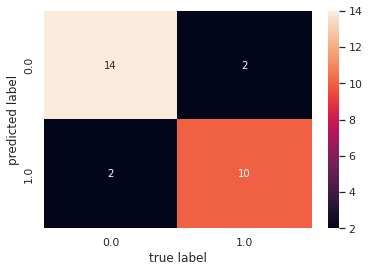

In [16]:
result = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
#confusion matrix
labels = sorted(finalized_df['90day-mortality'].unique())
ax = sns.heatmap(
confusion_matrix(y_val, y_pred),
annot=True,
xticklabels=labels,
yticklabels=labels
)
ax.set(xlabel='true label', ylabel='predicted label')

サンプル数が多い生存者に対する予測スコアは高い値を示す一方で，サンプル数の少ない死者に対しては，スコアが低くなる傾向があります．今回のデータセットのように，サンプルが占めるクラスの割合が極端に偏っている不均衡データでは，こうした傾向が観測されることが知られています．


#### Optuna

OptunaとはPreferred Networks社が出しているハイパーパラメータ自動化ツールです。Tree-structured Parzen Estimator というベイズ最適化アルゴリズムの一種を用いていて有望そうなハイパーパレメーターを正確に特定できます。
objective()というOptunaの目的関数を設定する関数でRandomForestClassifierのパラメーターを設定しています。
RandomForestClassifier()のパラメーターについて：
1.   criterion - 評価基準 (ジニ係数またはエントロピー)
2.   bootstrap - 決定木構築の際にブートストラップサンプルを使用するかどうか
3.   max_depth - 先のn_estimatorsで指定した決定木／回帰木の深さの指定
4.   max_features - 個々の決定木に、どれくらいの特徴量を使用するかを、表します
5.   max_leaf_nodes - 決定木をベスト・ファーストの方法で成長させる
6.   n_estimators - ベースとして利用する決定木／回帰木の数
7.   min_samples_split - 子ノードを分割するために必要なサンプルの最小数
8.   min_samples_leaf - リーフノードにある必要があるサンプルの最小数

詳しくはこちらを参照して下さい [[3](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)]。




In [17]:
def objective(trial):
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
  max_depth = trial.suggest_int('max_depth', 1, 1000)
  max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1,1000)
  n_estimators =  trial.suggest_int('n_estimators', 1, 1000)
  min_samples_split = trial.suggest_int('min_samples_split',2,5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10)

  regr = ensemble.RandomForestClassifier(
      bootstrap = bootstrap, criterion = criterion,
      max_depth = max_depth, max_features = max_features,
      max_leaf_nodes = max_leaf_nodes,n_estimators = n_estimators,
      min_samples_split = min_samples_split,min_samples_leaf = min_samples_leaf,
      n_jobs=2)

  score = cross_val_score(regr, X_train_op, y_train_op, cv=5, scoring="r2")
  r2_mean = score.mean()
  return r2_mean

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))

# チューニングしたハイパーパラメーターをフィット
rforest_model_post_optuna = ensemble.RandomForestClassifier(bootstrap = trial.params['bootstrap'], criterion = trial.params['criterion'],
                                     max_depth = trial.params['max_depth'], max_features = trial.params['max_features'],
                                     max_leaf_nodes = trial.params['max_leaf_nodes'],n_estimators = trial.params['n_estimators'],
                                     min_samples_split = trial.params['min_samples_split'],min_samples_leaf = trial.params['min_samples_leaf'],                                     
                                     n_jobs=2)

# モデルを再度トレーニングする
rforest_model_post_optuna.fit(X_train_op, y_train_op) 

# 再度トレーニングした後のモデルのパフォーマンス検証
# テストデータにrforest_modelに.predict()関数を応用し、RFモデルがラベルを何個正確に予測出来たかを検証する
y_pred_op = rforest_model_post_optuna.predict(X_val_op)

#モデルを作成する段階でのモデルの識別精度
trainaccuracy_random_forest_op = rforest_model_post_optuna.score(X_train_op, y_train_op)
print('TrainAccuracy: {}'.format(trainaccuracy_random_forest_op))

#作成したモデルに学習に使用していない評価用のデータセットを入力し精度を確認
accuracy_random_forest_op = accuracy_score(y_val_op, y_pred_op)
print('Accuracy: {}'.format(accuracy_random_forest_op))

# 正確性の出力
print(classification_report(y_val_op, y_pred_op))


[I 2022-05-26 02:29:06,130] A new study created in memory with name: no-name-7fab0daf-07f1-44f1-b0f9-a199ed3ed216
[I 2022-05-26 02:29:17,018] Trial 0 finished with value: -0.4004761904761903 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 706, 'max_features': 'log2', 'max_leaf_nodes': 722, 'n_estimators': 658, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: -0.4004761904761903.
[I 2022-05-26 02:29:25,574] Trial 1 finished with value: -0.5376190476190474 and parameters: {'criterion': 'entropy', 'bootstrap': 'True', 'max_depth': 898, 'max_features': 'log2', 'max_leaf_nodes': 79, 'n_estimators': 759, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: -0.4004761904761903.
[I 2022-05-26 02:29:29,593] Trial 2 finished with value: -0.27666666666666656 and parameters: {'criterion': 'gini', 'bootstrap': 'False', 'max_depth': 911, 'max_features': 'sqrt', 'max_leaf_nodes': 98, 'n_estimators': 462, 'min_samples_split':

Accuracy: 0.03285714285714296
TrainAccuracy: 0.828125
Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88        16
         1.0       0.83      0.83      0.83        12

    accuracy                           0.86        28
   macro avg       0.85      0.85      0.85        28
weighted avg       0.86      0.86      0.86        28



最適化の履歴をplot_optimization_history()メソッドを使い確認してみましょう。
縦軸が目的変数、横軸が最適化のトライアル数になってます。オレンジの折れ線が最良の目的変数の値となっており、何回目のトライアルでベストパラメータが出たのかわかりやすくなってます。

In [18]:
optuna.visualization.plot_optimization_history(study)

グラフをみてみると61回目のトライアルでベストパラメーターが出たのがわかりやくなっています。

In [19]:
optuna.visualization.plot_slice(study)

## 特徴量の重要度の評価

妥当性の検証を終え、クロスバリデーションとOptunaでより正確性が高かったモデルを使い、特徴量の重要度の評価を行います。
特徴量の重要度の評価はScikit-learnのランダムフォレストモデルライブラリのfeature_importances()という関数を使います。


In [24]:
if accuracy_random_forest_op > accuracy_random_forest:
  print("妥当性の検証方法でより正確だったのはOptunaです")
  feature_importances = rforest_model_post_optuna.feature_importances_
else:
  print("妥当性の検証方法でより正確だったのはCross Validationです")
  feature_importances = rforest_model_cv.feature_importances_

feature_importances_dict = {}

for i, importance in enumerate(feature_importances):
  perc = importance * 100
  feature_importances_dict[finalized_df.columns[i]] = perc # 一行目は出力行のため、考慮しない

sorted_dict = {}
sorted_keys = sorted(feature_importances_dict, key=feature_importances_dict.get)
for w in sorted_keys:
    sorted_dict[w] =  feature_importances_dict[w]
  
for keys in sorted_dict.keys():
  print(f"フィーチャー名：{keys:>12s}は出力データの結果に{sorted_dict[keys]:>7.2f}%関与しています")

妥当性の検証方法でより正確だったのはCross Validationです
フィーチャー名：         ageは出力データの結果に   0.00%関与しています
フィーチャー名：smoking-statusは出力データの結果に   0.00%関与しています
フィーチャー名：   emphysemaは出力データの結果に   0.00%関与しています
フィーチャー名：Baseline-ILDは出力データの結果に   0.00%関与しています
フィーチャー名：Collagen-diseaseは出力データの結果に   0.00%関与しています
フィーチャー名：        IPAFは出力データの結果に   0.00%関与しています
フィーチャー名：         CRPは出力データの結果に   0.00%関与しています
フィーチャー名：BAL(neutro-%)は出力データの結果に   0.00%関与しています
フィーチャー名：  BAL(Eos-%)は出力データの結果に   0.00%関与しています
フィーチャー名：    BAL(M-%)は出力データの結果に   0.00%関与しています
フィーチャー名：       TGFB1は出力データの結果に   0.00%関与しています
フィーチャー名：       TGF-aは出力データの結果に   0.00%関与しています
フィーチャー名：       G-CSFは出力データの結果に   0.00%関与しています
フィーチャー名：      Flt-3Lは出力データの結果に   0.00%関与しています
フィーチャー名： FRACTALKINEは出力データの結果に   0.00%関与しています
フィーチャー名：      IFN-a2は出力データの結果に   0.00%関与しています
フィーチャー名：    IL-12P40は出力データの結果に   0.00%関与しています
フィーチャー名：         MDCは出力データの結果に   0.00%関与しています
フィーチャー名：    IL-12P70は出力データの結果に   0.00%関与しています
フィーチャー名：      sCD40Lは出力データの結果に   0.00%関与しています
フィーチャー名：       IL-17は出力データの結果に   0.0

##  特徴量の重要度の評価に基づきモデル再構築

特徴量設計は、モデルタイプやそのパラメータよりもモデルの品質に大きな影響を与えるという共通認識があります。特徴量選択が重要な問題である理由として、実際のパターンを隠してしまうほどの余分な特徴量で学習してしまうと、本来のパターンを見つけるのが難しくなります。この場合、モデルは不要な特徴量のノイズパターンを使用し始め、結果としてパフォーマンスの低下につながります。加え、特徴量の数を減らすと、一般的にモデルの学習（トレーニング）が大幅に速くなります。そして大抵の場合、結果として得られるモデルは単純で理解しやすいものとなります。常に単純なモデルになるように心がけ、ノイズを削除し、ロバストなモデル作成を心がける必要があります。詳しくはこちらを参照して下さい [[4](https://www.rapidminer.jp/wp-content/uploads/2020/05/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AE%E3%81%9F%E3%82%81%E3%81%AE%E7%89%B9%E5%BE%B4%E9%87%8F%E6%9C%80%E9%81%A9%E5%8C%96.pdf)]。

今回はForward Selectionという考え方を応用し、特徴量の重要度の評価で最も正答率が高かった10個の属性を保持して再度モデルを作成します。

In [25]:
top_ten_params = list(sorted_dict.keys())[-10:]
top_ten_params.append('90day-mortality')
print(f"The top ten parameters are: {top_ten_params}")

# 最後に使用したPandasデータフレームをコピーを作成する
finalized_df_c = finalized_df.copy()

# 新しいデータフレームから重要因子以外を取り除く
finalized_df_c = finalized_df_c.drop(columns=[col for col in finalized_df.columns if col not in top_ten_params])

# 行数と列数を変数として保管する
NUM_ROWS, NUM_COLS = finalized_df_c.shape[0], finalized_df_c.shape[1]

# Y (ラベル) ターゲットラベル
Y_col = '90day-mortality'
# X (フィーチャー) ターゲットラベル以外の全ての行
X_cols = finalized_df_c.loc[:, finalized_df_c.columns != Y_col].columns

X_train, X_val, y_train, y_val = \
train_test_split(finalized_df_c[X_cols], finalized_df_c[Y_col],test_size=0.2, random_state=42)

print("X_train.shape = ", X_train.shape, " \t y_train.shape = ", y_train.shape)
print("X_val.shape = ", X_val.shape, " \t y_val.shape = ", y_val.shape)

if accuracy_random_forest_op > accuracy_random_forest:
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=100)

  trial = study.best_trial
  print('Accuracy: {}'.format(trial.value))

  # チューニングしたハイパーパラメーターをフィット
  rforest_model_forward_selection = ensemble.RandomForestClassifier(bootstrap = trial.params['bootstrap'], criterion = trial.params['criterion'],
                                     max_depth = trial.params['max_depth'], max_features = trial.params['max_features'],
                                     max_leaf_nodes = trial.params['max_leaf_nodes'],n_estimators = trial.params['n_estimators'],
                                     min_samples_split = trial.params['min_samples_split'],min_samples_leaf = trial.params['min_samples_leaf'],                                     
                                     n_jobs=2)


else:
  # cross validationを使い、階層や決定木の数をチューニングしてみる（ハイパーパラメーター）
  # 注：過適合/過剰適合のバランスを見極めながらハイパーパラメーターチューニングを行う
  best_accuracy = 0
  best_depth = 1
  best_num_trees = 42

  for ntrees in range(50,450,100):  # 決定木50から350の間（ステップ数：100)
      for d in range(1,20): # 階層1から20の間
          rforest_model = ensemble.RandomForestClassifier(
              n_estimators= ntrees,
              criterion='gini',
              max_depth=d,
              min_samples_split=2,
              min_samples_leaf=1,
              min_weight_fraction_leaf=0.0,
              max_features='auto',
              max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              bootstrap=True,
              oob_score=False,
              n_jobs=-1,
              random_state=0,
              verbose=0,
              warm_start=False,
              class_weight='balanced'
          )
          cv_scores = cross_val_score( rforest_model, X_train, y_train, cv=5 ) # 5 はトレーニング・テストの割合が8割・2割ということを表す
          average_cv_accuracy = cv_scores.mean()  # cvスコアの平均値cv=5はスコアを五つ出すため、その平均値を見る
          if average_cv_accuracy >= best_accuracy: # cvスコアの平均値正確性が現在の最適正確性を上回った場合、現在のcvスコア平均値を出した決定木数・階層を最適とする
              best_accuracy = average_cv_accuracy
              best_depth = d
              best_num_trees = ntrees

  print()
  print(f"最適層: {best_depth}, 最適決定木数： {best_num_trees}, 最高予測精度：{best_accuracy}")

  # 上記で見つけた最適層・最適決定木数をもとにモデルの構築・モデルのトレーニング
  rforest_model_forward_selection = ensemble.RandomForestClassifier(max_depth=best_depth, n_estimators=best_num_trees) # ensemble.RandomForestClassifierからRF解析モデルを引っ張ってくる

# モデルを再度トレーニングする
rforest_model_forward_selection.fit(X_train, y_train) 

# 再度トレーニングした後のモデルのパフォーマンス検証
# テストデータにrforest_modelに.predict()関数を応用し、RFモデルがラベルを何個正確に予測出来たかを検証する
y_pred_op = rforest_model_forward_selection.predict(X_val)

#モデルを作成する段階でのモデルの識別精度
trainaccuracy_random_forest = rforest_model_forward_selection.score(X_train, y_train)
print('TrainAccuracy: {}'.format(trainaccuracy_random_forest))

#作成したモデルに学習に使用していない評価用のデータセットを入力し精度を確認
accuracy_random_forest = accuracy_score(y_val, y_pred_op)
print('Accuracy: {}'.format(accuracy_random_forest))

# 正確性の出力
print(classification_report(y_val, y_pred_op))

# フィーチャーの重要度を出力するコード
feature_importances_opt = rforest_model_forward_selection.feature_importances_

feature_importances_dict = {}
for i, importance in enumerate(feature_importances_opt):
  perc = importance * 100
  feature_importances_dict[finalized_df_c.columns[i]] = perc

sorted_dict = {}
sorted_keys = sorted(feature_importances_dict, key=feature_importances_dict.get)
for w in sorted_keys:
    sorted_dict[w] =  feature_importances_dict[w]
  
for keys in sorted_dict.keys():
  print(f"フィーチャー名：{keys:>12s}は出力データの結果に{sorted_dict[keys]:>7.2f}%関与しています")

The top ten parameters are: ['MCP-3', 'IL-8', 'MCP-1', 'LDH', 'KL-6', 'TGFB3', 'GM-CSF', 'IL-5', 'EGF', 'MMP-1', '90day-mortality']
X_train.shape =  (73, 10)  	 y_train.shape =  (73,)
X_val.shape =  (19, 10)  	 y_val.shape =  (19,)

最適層: 1, 最適決定木数： 150, 最高予測精度：0.6980952380952381
TrainAccuracy: 0.7945205479452054
Accuracy: 0.9473684210526315
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       1.00      0.88      0.93         8

    accuracy                           0.95        19
   macro avg       0.96      0.94      0.94        19
weighted avg       0.95      0.95      0.95        19

フィーチャー名：       MCP-3は出力データの結果に   7.33%関与しています
フィーチャー名：         LDHは出力データの結果に   8.00%関与しています
フィーチャー名：      GM-CSFは出力データの結果に   8.00%関与しています
フィーチャー名：       MCP-1は出力データの結果に   8.00%関与しています
フィーチャー名：       TGFB3は出力データの結果に   8.67%関与しています
フィーチャー名：        IL-8は出力データの結果に  10.00%関与しています
フィーチャー名：       MMP-1は出力データの結果に  10.67%関与しています
フィーチャー名：

混同行列で予測結果を確認していきましょう。

Confusion Matrix:


[Text(30.5, 0.5, 'predicted label'), Text(0.5, 12.5, 'true label')]

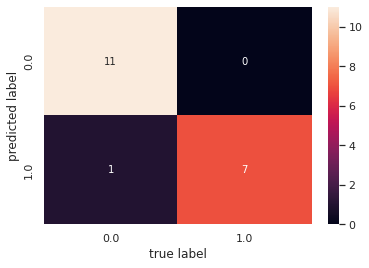

In [26]:
result = confusion_matrix(y_val, y_pred_op)
print("Confusion Matrix:")
#confusion matrix
labels = sorted(finalized_df_c['90day-mortality'].unique())
ax = sns.heatmap(
confusion_matrix(y_val, y_pred_op),
annot=True,
xticklabels=labels,
yticklabels=labels
)
ax.set(xlabel='true label', ylabel='predicted label')

## 学習モデルの保存

モデルは訓練中にも、訓練が終わったあとも保存できます。このことは、長い訓練時間を掛けなくても、やめたところから再開できるということを意味します。モデルが保存可能であることは、あなたが作ったモデルを他の人と共有できるということでもあります。

保存方法としてはJoblibというSciPyのライブラリを使用します。JoblibはPythonのジョブをパイプライン処理するためのユーティリティを提供しています。NumPyデータ構造を効率的に利用するPythonオブジェクトの保存とロードを行うユーティリティを提供します。

TrainAccuracy: 0.8333333333333334
Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        15
         1.0       0.00      0.00      0.00         3

    accuracy                           0.83        18
   macro avg       0.42      0.50      0.45        18
weighted avg       0.69      0.83      0.76        18

Confusion Matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



[Text(30.5, 0.5, 'predicted label'), Text(0.5, 12.5, 'true label')]

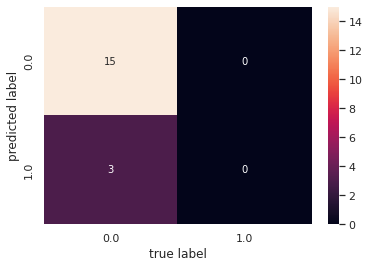

In [29]:
# モデルを./outに保存
filename = 'out/finalized_model.joblib'
joblib.dump(rforest_model_forward_selection, filename)

# モデルをGoogle Driveに保存
!cp 'out/finalized_model.joblib' '/content/drive/MyDrive/shibaki analysis/'

# モデルをGoogle Driveからロードしたい場合
loaded_model_forward_selection = joblib.load("/content/drive/MyDrive/shibaki analysis/finalized_model.joblib")

# テスト用データフレームから重要因子以外を取り除く
X_test = X_test.drop(columns=[col for col in X_test.columns if col not in top_ten_params])

# 検証データにrforest_modelに.predict()関数を応用し、RFモデルがラベルを何個正確に予測出来たかを検証する
y_pred_final = loaded_model_forward_selection.predict(X_test)

#モデルを作成する段階でのモデルの識別精度
trainaccuracy_random_forest_final = loaded_model_forward_selection.score(X_test, y_test)
print('TrainAccuracy: {}'.format(trainaccuracy_random_forest_final))

#作成したモデルに学習に使用していない評価用のデータセットを入力し精度を確認
accuracy_random_forest_final = accuracy_score(y_test, y_pred_final)
print('Accuracy: {}'.format(accuracy_random_forest_final))

# 正確性の出力
print(classification_report(y_test, y_pred_final))

result = confusion_matrix(y_test, y_pred_final)
print("Confusion Matrix:")

#confusion matrix
labels = sorted(finalized_df_c['90day-mortality'].unique())
ax = sns.heatmap(
confusion_matrix(y_test, y_pred_final),
annot=True,
xticklabels=labels,
yticklabels=labels
)
ax.set(xlabel='true label', ylabel='predicted label')

## 終わりに

今研究では、和歌山医科大学の保有する、線維化を伴う間質性肺炎の急性増悪の多施設後ろ向き実態調査に登録された患者において急性増悪中に施行されたBAL液中のサイトカインやケモカインのデータを用いて、間質性肺炎の予後予測因子の抽出と予後予測に取り組みました。

解析内容の要約は以下となります。
1.   環境構築
2.   データ前処理
3.   RF解析モデル構築
4.   妥当性の検証・ハイパーパラメーターチューニング
5.   特徴量重要度の評価
6.   特徴量重要の評価に基づきモデル再構築

精度向上に向けて様々な手法を試してみましたが，今回のタスクにおいては，どの工夫が有効に働くか自明で無い場合がほとんどです．従って，試行錯誤を行いながら，その問題設定に適合するやり方を模索していく必要があります．

さらなる取り組みとしては，例えば下記内容を検討する余地があります。


* クラス不均衡データへの対応
  - サンプリング
      - 不均衡データセットからサンプリングを行い，クラス比率のバランスが取れたデータセットを作成．
    - **Undersampling** : 大多数の正常サンプルを削減．
    - **Oversampling**  : 少数の異常サンプルを水増し．  
  - 損失関数の重み調整
    - 正常サンプルを異常と誤分類した際のペナルティを小さく，異常サンプルを正常と誤分類した際のペナルティを大きくする．
    - 例えば，サンプル数の存在比率の逆数を重みとして利用．
  - 目的関数(損失関数)の変更
    - 異常サンプルに対する予測スコアを向上させるような目的関数を導入．
  - 異常検知
    - 正常サンプルのデータ分布を仮定し，そこから十分に逸脱したサンプルを異常とみなす．

* 前処理の工夫
  - ラベルの追加
    - 生存者・死者加えて，新たな目的関数を考慮する．
  - ラベルの与え方の変更
      * セグメント範囲内に正常以外のピークラベルが含まれる場合に優先的にそのラベルを付与する，等．

* モデルの変更等
  - ランダムフォレスト以外の機械学習モデルを導入する


## 参考文献

**TODO: 柴木様**

